### Transformer Fine-tuning Model
> KU-HAR Dataset | tranfer learn/ learn on self-supervised learned transformer model

In [1]:
import logging

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info("Loading packages ...")

import os
import sys
import time
import pickle
import json
from argparse import Namespace

# 3rd party packages
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# Project modules
from src.options import Options
from src.running import setup, pipeline_factory, validate, check_progress, NEG_METRICS
from src.utils import utils
from src.datasets.data import data_factory, Normalizer
from src.datasets.datasplit import split_dataset
from src.models.ts_transformer import model_factory
from src.models.loss import get_loss_module
from src.optimizers import get_optimizer

import neptune.new as neptune

2022-09-23 07:53:53,351 | INFO : Loading packages ...


The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
run = neptune.init(
    project="FYP-Group22/Transformer-SSC",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

https://app.neptune.ai/FYP-Group22/Transformer-SSC/e/TRAN-29
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [3]:
config = {}
config["output_dir"] = './tmp'
config["seed"] = 123
config["gpu"] = "0" # activate gpu > o, on cpu > -1
config["n_proc"] = 1

# loading pre-trained model
config["load_model"] = './tmp/first_test/checkpoints/prep_model_last.pth'
config["resume"] = False
config["change_output"] = True
config["test_only"] = None
config["config_filepath"] = None

# experiment config
config["task"] = "classification"
config["experiment_name"] = "first_test"
config["no_timestamp"] = True

# dataset settings
config["limit_size"] = 300 
config["data_class"] = 'kuhar'
config["data_dir"] = '../../Data/KU-HAR_time_domain_subsamples_20750x300.csv'
config["val_ratio"] = 0.1 
config["test_ratio"] = 0.1 
config["norm_from"] = False 
config["normalization"] = None # 'standardization'
config["record_file"] = "./tmp/Imputation_records.xls"
config["records_file"] = "./tmp/records.xls"
config["num_workers"] = 0
config["console"] = True
config["save_all"] = False
config["comment"] = "mvts_transformer | KU-HAR dataset Self-Supervised Sinusoidal PosEnc | nipdep 1DConv processing layer | first test"

# test, val from seperate files 
config["test_pattern"] = False 
config["val_pattern"] = False 
config["test_from"] = False

# freeze model weight for fine-tunning
config["freeze"] = False

# if task is a imputation 
config["masking_ratio"] = 0.15
config["mean_mask_length"] = 5
config["mask_mode"] = "seperate"
config["mask_distribution"] = "geometric"
config["exclude_feats"] = None 
config["mask_feats"] = '0, 1'
config["start_hint"] = 0.0
config["end_hint"] = 0.0 
config["harden"] = True

# model parameters
config['model'] = 'transformer'
config["pos_encoding"] = "fixed"
config["d_model"] = 128 
config["dim_feedforward"] = 256
config["num_heads"] = 8
config["num_layers"] = 3
config["dropout"] = 0.1
config["activation"] = 'relu'
config["normalization_layer"] = "BatchNorm"
config["data_window_len"] = None 
config["max_seq_len"] = 300

# model training parameters
config["epochs"] = 10
config["lr"] = 0.0005
config["val_interval"] = 1
config["lr_step"] = '1000'
config["lr_factor"] = '0.1'
config["l2_reg"] = 0
config["global_reg"] = True
config["key_metric"] = "loss"
config["optimizer"] = "Adam"
config["batch_size"] = 32
config["print_interval"] = 1

setup(config)

2022-09-23 07:54:11,205 | INFO : Stored configuration file in './tmp\first_test'


{'output_dir': './tmp\\first_test',
 'seed': 123,
 'gpu': '0',
 'n_proc': 1,
 'load_model': './tmp/first_test/checkpoints/prep_model_last.pth',
 'resume': False,
 'change_output': True,
 'test_only': None,
 'config_filepath': None,
 'task': 'classification',
 'experiment_name': 'first_test',
 'no_timestamp': True,
 'limit_size': 300,
 'data_class': 'kuhar',
 'data_dir': '../../Data/KU-HAR_time_domain_subsamples_20750x300.csv',
 'val_ratio': 0.1,
 'test_ratio': 0.1,
 'norm_from': False,
 'normalization': 'normalization',
 'record_file': './tmp/Imputation_records.xls',
 'records_file': './tmp/records.xls',
 'num_workers': 0,
 'console': True,
 'save_all': False,
 'comment': 'mvts_transformer | KU-HAR dataset Self-Supervised Sinusoidal PosEnc | nipdep 1DConv processing layer | first test',
 'test_pattern': False,
 'val_pattern': False,
 'test_from': False,
 'freeze': False,
 'masking_ratio': 0.15,
 'mean_mask_length': 5,
 'mask_mode': 'seperate',
 'mask_distribution': 'geometric',
 'exclu

In [4]:
run["parameters"] = config
# config['class_names'] = ['Talk-sit', 'Talk-stand', 'Stand-sit', 'Lay-stand', 'Pick', 'Jump', 'Push-up', 'Sit-up', 'Walk', 'Walk-backward', 'Walk-circle', 'Run', 'Stair-up', 'Stair-down', 'Table-tennis']
config['class_names'] = ['Stand', 'Sit', 'Talk-sit', 'Talk-stand', 'Stand-sit', 'Lay', 'Lay-stand', 'Pick', 'Jump', 'Push-up', 'Sit-up', 'Walk', 'Walk-backward', 'Walk-circle', 'Run', 'Stair-up', 'Stair-down', 'Table-tennis']

In [5]:
total_epoch_time = 0
total_eval_time = 0

total_start_time = time.time()

# Add file logging besides stdout
file_handler = logging.FileHandler(os.path.join(config['output_dir'], 'output.log'))
logger.addHandler(file_handler)

logger.info('Running:\n{}\n'.format(' '.join(sys.argv)))  # command used to run

if config['seed'] is not None:
    torch.manual_seed(config['seed'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info("Using device: {}".format(device))
if device == 'cuda':
    logger.info("Device index: {}".format(torch.cuda.current_device()))

2022-09-23 07:54:11,415 | INFO : Running:
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9008 --control=9006 --hb=9005 --Session.signature_scheme="hmac-sha256" --Session.key=b"09ed46ab-ee35-45c4-ab66-9d85115a63db" --shell=9007 --transport="tcp" --iopub=9009 --f=c:\Users\deela\AppData\Roaming\jupyter\runtime\kernel-v2-5900mdarkv1qE15I.json

2022-09-23 07:54:11,501 | INFO : Using device: cuda


In [6]:
# Build data
logger.info("Loading and preprocessing data ...")
data_class = data_factory[config['data_class']]
my_data = data_class(config['data_dir'], n_proc=config['n_proc'], limit_size=config['limit_size'], config=config, filter_classes=[])
feat_dim = my_data.feature_df.shape[1]  # dimensionality of data features
if config['task'] == 'classification':
    validation_method = 'StratifiedShuffleSplit'
    labels = my_data.labels_df.label.values
    print(labels)
else:
    validation_method = 'ShuffleSplit'
    labels = None

2022-09-23 07:54:11,664 | INFO : Loading and preprocessing data ...


[0 0 0 ... 9 9 9]


In [7]:
# Split dataset
test_data = my_data
test_indices = None  # will be converted to empty list in `split_dataset`, if also test_set_ratio == 0
val_data = my_data
val_indices = []
if config['test_pattern']:  # used if test data come from different files / file patterns
    test_data = data_class(config['data_dir'], n_proc=-1, config=config)
    test_indices = test_data.all_IDs
if config['test_from']:  # load test IDs directly from file, if available, otherwise use `test_set_ratio`. Can work together with `test_pattern`
    test_indices = list(set([line.rstrip() for line in open(config['test_from']).readlines()]))
    try:
        test_indices = [int(ind) for ind in test_indices]  # integer indices
    except ValueError:
        pass  # in case indices are non-integers
    logger.info("Loaded {} test IDs from file: '{}'".format(len(test_indices), config['test_from']))
if config['val_pattern']:  # used if val data come from different files / file patterns
    val_data = data_class(config['data_dir'], n_proc=-1, config=config)
    val_indices = val_data.all_IDs

# Note: currently a validation set must exist, either with `val_pattern` or `val_ratio`
# Using a `val_pattern` means that `val_ratio` == 0 and `test_ratio` == 0
if config['val_ratio'] > 0:
    train_indices, val_indices, test_indices = split_dataset(data_indices=my_data.all_IDs,
                                                                validation_method=validation_method,
                                                                n_splits=1,
                                                                validation_ratio=config['val_ratio'],
                                                                test_set_ratio=config['test_ratio'],  # used only if test_indices not explicitly specified
                                                                test_indices=test_indices,
                                                                random_seed=1337,
                                                                labels=labels)
    train_indices = train_indices[0]  # `split_dataset` returns a list of indices *per fold/split*
    val_indices = val_indices[0]  # `split_dataset` returns a list of indices *per fold/split*
else:
    train_indices = my_data.all_IDs
    if test_indices is None:
        test_indices = []

logger.info("{} samples may be used for training".format(len(train_indices)))
logger.info("{} samples will be used for validation".format(len(val_indices)))
logger.info("{} samples will be used for testing".format(len(test_indices)))

with open(os.path.join(config['output_dir'], 'data_indices.json'), 'w') as f:
    try:
        json.dump({'train_indices': list(map(int, train_indices)),
                    'val_indices': list(map(int, val_indices)),
                    'test_indices': list(map(int, test_indices))}, f, indent=4)
    except ValueError:  # in case indices are non-integers
        json.dump({'train_indices': list(train_indices),
                    'val_indices': list(val_indices),
                    'test_indices': list(test_indices)}, f, indent=4)

2022-09-23 07:56:03,840 | INFO : 16806 samples may be used for training
2022-09-23 07:56:03,841 | INFO : 1868 samples will be used for validation
2022-09-23 07:56:03,842 | INFO : 2075 samples will be used for testing


In [8]:
# Pre-process features
normalizer = None
if config['norm_from']:
    with open(config['norm_from'], 'rb') as f:
        norm_dict = pickle.load(f)
    normalizer = Normalizer(**norm_dict)
elif config['normalization'] is not None:
    normalizer = Normalizer(config['normalization'])
    my_data.feature_df.loc[train_indices] = normalizer.normalize(my_data.feature_df.loc[train_indices])
    if not config['normalization'].startswith('per_sample'):
        # get normalizing values from training set and store for future use
        norm_dict = normalizer.__dict__
        with open(os.path.join(config['output_dir'], 'normalization.pickle'), 'wb') as f:
            pickle.dump(norm_dict, f, pickle.HIGHEST_PROTOCOL)
if normalizer is not None:
    if len(val_indices):
        print("Validation dataset normalization")
        val_data.feature_df.loc[val_indices] = normalizer.normalize(val_data.feature_df.loc[val_indices])
    if len(test_indices):
        print("Test dataset normalization")
        test_data.feature_df.loc[test_indices] = normalizer.normalize(test_data.feature_df.loc[test_indices])

Validation dataset normalization
Test dataset normalization


In [9]:
# Create model
logger.info("Creating model ...")
model = model_factory(config, my_data)

if config['freeze']:
    for name, param in model.named_parameters():
        if name.startswith('output_layer'):
            param.requires_grad = True
        else:
            param.requires_grad = False

logger.info("Model:\n{}".format(model))
logger.info("Total number of parameters: {}".format(utils.count_parameters(model)))
logger.info("Trainable parameters: {}".format(utils.count_parameters(model, trainable=True)))


2022-09-23 07:56:21,218 | INFO : Creating model ...
2022-09-23 07:56:21,307 | INFO : Model:
TSTransformerEncoderClassiregressor(
  (project_inp): Linear(in_features=6, out_features=128, bias=True)
  (pos_enc): FixedPositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (d

In [10]:
# Initialize optimizer

if config['global_reg']:
    weight_decay = config['l2_reg']
    output_reg = None
else:
    weight_decay = 0
    output_reg = config['l2_reg']

optim_class = get_optimizer(config['optimizer'])
optimizer = optim_class(model.parameters(), lr=config['lr'], weight_decay=weight_decay)

start_epoch = 0
lr_step = 0  # current step index of `lr_step`
lr = config['lr']  # current learning step
# Load model and optimizer state
if config["load_model"]:
    model, optimizer, start_epoch = utils.load_model(model, config['load_model'], optimizer, config['resume'],
                                                        config['change_output'],
                                                        config['lr'],
                                                        config['lr_step'],
                                                        config['lr_factor'])
model.to(device)

loss_module = get_loss_module(config)

if config['test_only'] == 'testset':  # Only evaluate and skip training
    dataset_class, collate_fn, runner_class = pipeline_factory(config)
    test_dataset = dataset_class(test_data, test_indices)

    test_loader = DataLoader(dataset=test_dataset,
                                batch_size=config['batch_size'],
                                shuffle=False,
                                num_workers=config['num_workers'],
                                pin_memory=True,
                                collate_fn=lambda x: collate_fn(x, max_len=model.max_len))
    test_evaluator = runner_class(model, test_loader, device, loss_module,
                                        print_interval=config['print_interval'], console=config['console'])
    aggr_metrics_test, per_batch_test = test_evaluator.evaluate(keep_all=True)
    print_str = 'Test Summary: '
    for k, v in aggr_metrics_test.items():
        print_str += '{}: {:8f} | '.format(k, v)
    logger.info(print_str)
    # return

Loaded model from ./tmp/first_test/checkpoints/prep_model_last.pth. Epoch: 7


In [11]:
# Initialize data generators
dataset_class, collate_fn, runner_class = pipeline_factory(config)
val_dataset = dataset_class(val_data, val_indices)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=config['batch_size'],
                        shuffle=False,
                        num_workers=config['num_workers'],
                        pin_memory=True,
                        collate_fn=lambda x: collate_fn(x, max_len=model.max_len))

train_dataset = dataset_class(my_data, train_indices)

train_loader = DataLoader(dataset=train_dataset,
                            batch_size=config['batch_size'],
                            shuffle=True,
                            num_workers=config['num_workers'],
                            pin_memory=True,
                            collate_fn=lambda x: collate_fn(x, max_len=model.max_len))

trainer = runner_class(model, train_loader, device, loss_module, optimizer, l2_reg=output_reg,
                                print_interval=config['print_interval'], console=config['console'])
val_evaluator = runner_class(model, val_loader, device, loss_module,
                                    print_interval=config['print_interval'], console=config['console'])

tensorboard_writer = SummaryWriter(config['tensorboard_dir'])

best_value = 1e16 if config['key_metric'] in NEG_METRICS else -1e16  # initialize with +inf or -inf depending on key metric
metrics = []  # (for validation) list of lists: for each epoch, stores metrics like loss, ...
best_metrics = {}

In [12]:
# for i in train_loader:
#     print(i)
#     break

2022-09-23 07:56:30,919 | INFO : Evaluating on validation set ...


Evaluating Epoch 0  98.3% | batch:        58 of        59	|	loss: 2.88109

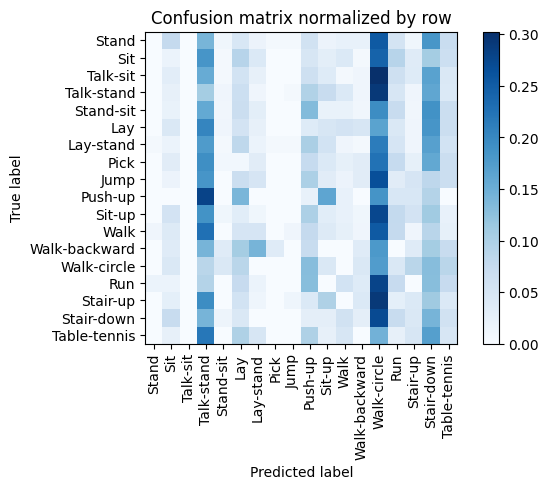

Overall accuracy: 0.035

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.125      0.010      0.019      0.105        196|	 Walk-circle: 0.194,	Stair-down: 0.189,	Talk-stand: 0.158,	
        Stand       0.000      0.000      0.000      0.091        170|	 Walk-circle: 0.253,	Stair-down: 0.182,	Talk-stand: 0.141,	
          Sit       0.048      0.018      0.026      0.090        169|	 Walk-circle: 0.243,	Talk-stand: 0.183,	Stair-down: 0.107,	
   Talk-stand       0.057      0.107      0.075      0.090        168|	 Walk-circle: 0.292,	Stair-down: 0.161,	
          Lay       0.078      0.055      0.065      0.087        163|	 Talk-stand: 0.202,	Stair-down: 0.184,	Walk-circle: 0.166,	
     Talk-sit       0.000      0.000      0.000      0.087        162|	 Walk-circle: 0.302,	Stair-down: 0.167,	Talk-stand: 0.154,	
    Lay-stand       0.061      0.019      0.029      0.085        159|	 Walk-circle: 0.214,	Talk-stand: 0.176,	Stair-do

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-09-23 07:56:45,318 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 14.397812128067017 seconds

2022-09-23 07:56:45,319 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 14.397812128067017 seconds
2022-09-23 07:56:45,320 | INFO : Avg batch val. time: 0.24403071403503418 seconds
2022-09-23 07:56:45,320 | INFO : Avg sample val. time: 0.007707608205603328 seconds
2022-09-23 07:56:45,322 | INFO : Epoch 0 Validation Summary: epoch: 0.000000 | loss: 0.091980 | accuracy: 0.034797 | precision: 0.048174 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences 




Distribution of classes with respect to PRECISION: 
[0.0, 0.2): 18
[0.2, 0.4): 0
[0.4, 0.6): 0
[0.6, 0.7): 0
[0.7, 0.8): 0
[0.8, 0.9): 0
[0.9, 1.0): 0
[1.0, 1.1): 0


Distribution of classes with respect to RECALL: 
[0.0, 0.2): 18
[0.2, 0.4): 0
[0.4, 0.6): 0
[0.6, 0.7): 0
[0.7, 0.8): 0
[0.8, 0.9): 0
[0.9, 1.0): 0
[1.0, 1.1): 0



Training Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 1  99.8% | batch:       525 of       526	|	loss: 2.57947

2022-09-23 08:00:23,212 | INFO : Epoch 1 Training Summary: epoch: 1.000000 | loss: 0.085168 | 
2022-09-23 08:00:23,212 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 37.80230140686035 seconds

2022-09-23 08:00:23,213 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 37.80230140686035 seconds
2022-09-23 08:00:23,214 | INFO : Avg batch train. time: 0.41407281636285237 seconds
2022-09-23 08:00:23,214 | INFO : Avg sample train. time: 0.012959794204859 seconds
2022-09-23 08:00:23,215 | INFO : Evaluating on validation set ...


Evaluating Epoch 1  98.3% | batch:        58 of        59	|	loss: 2.62303

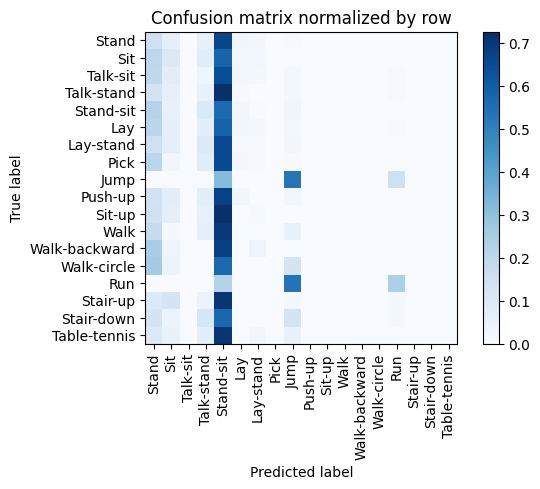

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-09-23 08:00:30,480 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 7.264337062835693 seconds

2022-09-23 08:00:30,481 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 10.831074595451355 seconds
2022-09-23 08:00:30,482 | INFO : Avg batch val. time: 0.18357753551612466 seconds
2022-09-23 08:00:30,482 | INFO : Avg sample val. time: 0.005798219804845479 seconds
2022-09-23 08:00:30,484 | INFO : Epoch 1 Validation Summary: epoch: 1.000000 | loss: 0.082642 | accuracy: 0.113490 | precision: 0.132653 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (

Overall accuracy: 0.113

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.095      0.561      0.163      0.105        196|	 Stand: 0.219,	Talk-stand: 0.102,	
        Stand       0.085      0.153      0.109      0.091        170|	 Stand-sit: 0.665,	Sit: 0.065,	
          Sit       0.153      0.101      0.121      0.090        169|	 Stand-sit: 0.580,	Stand: 0.201,	
   Talk-stand       0.074      0.054      0.062      0.090        168|	 Stand-sit: 0.726,	Stand: 0.131,	Sit: 0.060,	
          Lay       0.160      0.025      0.043      0.087        163|	 Stand-sit: 0.583,	Stand: 0.209,	Talk-stand: 0.074,	
     Talk-sit       0.000      0.000      0.000      0.087        162|	 Stand-sit: 0.642,	Stand: 0.198,	Sit: 0.074,	
    Lay-stand       0.056      0.006      0.011      0.085        159|	 Stand-sit: 0.654,	Stand: 0.151,	Talk-stand: 0.094,	
         Pick       0.000      0.000      0.000      0.064        120|	 Stand-sit: 0.650,	

2022-09-23 08:04:05,691 | INFO : Epoch 2 Training Summary: epoch: 2.000000 | loss: 0.079745 | 
2022-09-23 08:04:05,692 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 35.13664937019348 seconds

2022-09-23 08:04:05,694 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 36.46947538852692 seconds
2022-09-23 08:04:05,695 | INFO : Avg batch train. time: 0.41153892659415764 seconds
2022-09-23 08:04:05,697 | INFO : Avg sample train. time: 0.012880487646586154 seconds
2022-09-23 08:04:05,698 | INFO : Evaluating on validation set ...


Evaluating Epoch 2  98.3% | batch:        58 of        59	|	loss: 2.56087

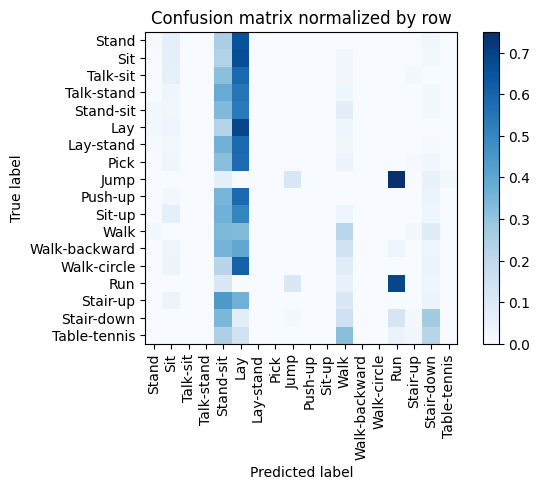

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-09-23 08:04:12,581 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 6.882072448730469 seconds

2022-09-23 08:04:12,581 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 9.514740546544393 seconds
2022-09-23 08:04:12,582 | INFO : Avg batch val. time: 0.16126678892448124 seconds
2022-09-23 08:04:12,582 | INFO : Avg sample val. time: 0.005093544189798926 seconds
2022-09-23 08:04:12,584 | INFO : Epoch 2 Validation Summary: epoch: 2.000000 | loss: 0.077986 | accuracy: 0.144540 | precision: 0.161819 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (w

Overall accuracy: 0.145

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.117      0.337      0.174      0.105        196|	 Lay: 0.536,	Walk: 0.071,	
        Stand       0.111      0.006      0.011      0.091        170|	 Lay: 0.653,	Stand-sit: 0.253,	Sit: 0.065,	
          Sit       0.164      0.065      0.093      0.090        169|	 Lay: 0.663,	Stand-sit: 0.237,	
   Talk-stand       0.000      0.000      0.000      0.090        168|	 Lay: 0.548,	Stand-sit: 0.381,	Sit: 0.030,	
          Lay       0.118      0.687      0.202      0.087        163|	 Stand-sit: 0.227,	Sit: 0.037,	
     Talk-sit       0.000      0.000      0.000      0.087        162|	 Lay: 0.586,	Stand-sit: 0.315,	Sit: 0.062,	
    Lay-stand       0.000      0.000      0.000      0.085        159|	 Lay: 0.585,	Stand-sit: 0.358,	Walk: 0.025,	
         Pick       0.000      0.000      0.000      0.064        120|	 Lay: 0.575,	Stand-sit: 0.317,	Walk: 0.042,	
     

2022-09-23 08:07:45,316 | INFO : Epoch 3 Training Summary: epoch: 3.000000 | loss: 0.076093 | 
2022-09-23 08:07:45,317 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 32.71212124824524 seconds

2022-09-23 08:07:45,318 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 35.217024008433015 seconds
2022-09-23 08:07:45,318 | INFO : Avg batch train. time: 0.40915784032021485 seconds
2022-09-23 08:07:45,319 | INFO : Avg sample train. time: 0.012805963584935917 seconds
2022-09-23 08:07:45,320 | INFO : Evaluating on validation set ...


Evaluating Epoch 3  98.3% | batch:        58 of        59	|	loss: 2.35142

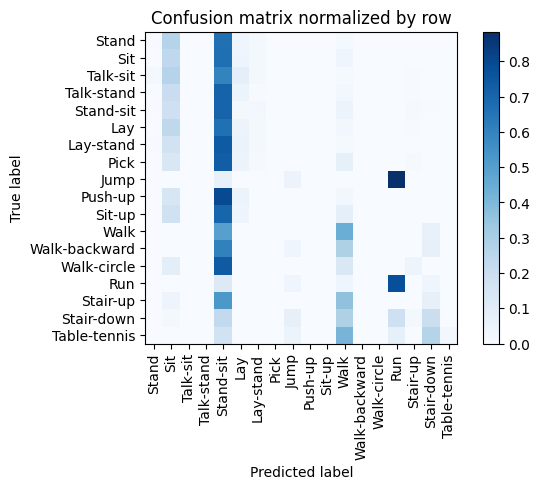

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-09-23 08:07:52,225 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 6.903997421264648 seconds

2022-09-23 08:07:52,226 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 8.862054765224457 seconds
2022-09-23 08:07:52,227 | INFO : Avg batch val. time: 0.15020431805465181 seconds
2022-09-23 08:07:52,227 | INFO : Avg sample val. time: 0.004744140666608381 seconds
2022-09-23 08:07:52,228 | INFO : Epoch 3 Validation Summary: epoch: 3.000000 | loss: 0.074778 | accuracy: 0.152570 | precision: 0.188610 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (w

Overall accuracy: 0.153

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.122      0.704      0.208      0.105        196|	 Sit: 0.184,	Walk: 0.051,	
        Stand       0.167      0.006      0.011      0.091        170|	 Stand-sit: 0.665,	Sit: 0.265,	Lay: 0.035,	
          Sit       0.130      0.237      0.168      0.090        169|	 Stand-sit: 0.669,	Lay: 0.041,	
   Talk-stand       0.000      0.000      0.000      0.090        168|	 Stand-sit: 0.708,	Sit: 0.202,	Lay: 0.054,	
          Lay       0.119      0.049      0.070      0.087        163|	 Stand-sit: 0.663,	Sit: 0.239,	
     Talk-sit       0.000      0.000      0.000      0.087        162|	 Stand-sit: 0.599,	Sit: 0.265,	Lay: 0.080,	
    Lay-stand       0.136      0.019      0.033      0.085        159|	 Stand-sit: 0.736,	Sit: 0.170,	Lay: 0.057,	
         Pick       0.000      0.000      0.000      0.064        120|	 Stand-sit: 0.725,	Sit: 0.133,	Walk: 0.075,	
      

2022-09-23 08:11:31,532 | INFO : Epoch 4 Training Summary: epoch: 4.000000 | loss: 0.073967 | 
2022-09-23 08:11:31,533 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 39.28397297859192 seconds

2022-09-23 08:11:31,534 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 36.23376125097275 seconds
2022-09-23 08:11:31,535 | INFO : Avg batch train. time: 0.41109080085736266 seconds
2022-09-23 08:11:31,536 | INFO : Avg sample train. time: 0.012866462052301127 seconds
2022-09-23 08:11:31,537 | INFO : Evaluating on validation set ...


Evaluating Epoch 4  98.3% | batch:        58 of        59	|	loss: 2.14201

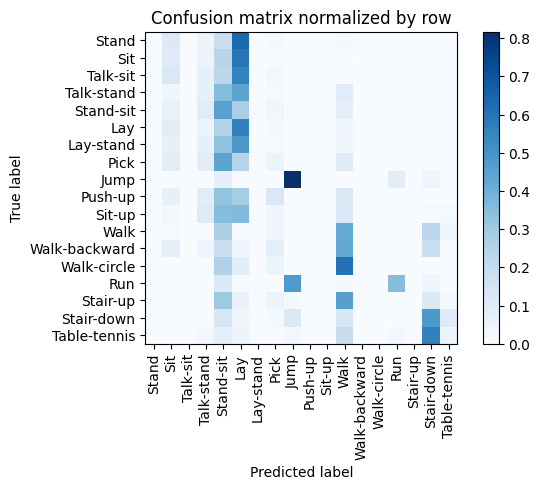

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-09-23 08:11:38,566 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 7.0280187129974365 seconds

2022-09-23 08:11:38,567 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 8.495247554779052 seconds
2022-09-23 08:11:38,567 | INFO : Avg batch val. time: 0.14398724669117038 seconds
2022-09-23 08:11:38,568 | INFO : Avg sample val. time: 0.004547777063586216 seconds
2022-09-23 08:11:38,569 | INFO : Epoch 4 Validation Summary: epoch: 4.000000 | loss: 0.071818 | accuracy: 0.187901 | precision: 0.184062 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (

Overall accuracy: 0.188

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.169      0.454      0.247      0.105        196|	 Lay: 0.276,	Talk-stand: 0.092,	
        Stand       0.000      0.000      0.000      0.091        170|	 Lay: 0.629,	Stand-sit: 0.182,	Sit: 0.106,	
          Sit       0.147      0.101      0.119      0.090        169|	 Lay: 0.598,	Stand-sit: 0.237,	
   Talk-stand       0.111      0.065      0.082      0.090        168|	 Lay: 0.440,	Stand-sit: 0.351,	Walk: 0.095,	
          Lay       0.134      0.558      0.216      0.087        163|	 Stand-sit: 0.258,	Sit: 0.092,	
     Talk-sit       0.000      0.000      0.000      0.087        162|	 Lay: 0.556,	Stand-sit: 0.228,	Sit: 0.117,	
    Lay-stand       0.000      0.000      0.000      0.085        159|	 Lay: 0.484,	Stand-sit: 0.333,	Sit: 0.069,	
         Pick       0.133      0.050      0.073      0.064        120|	 Stand-sit: 0.442,	Lay: 0.242,	Walk: 0.100,	

2022-09-23 08:15:13,376 | INFO : Epoch 5 Training Summary: epoch: 5.000000 | loss: 0.071301 | 
2022-09-23 08:15:13,377 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 34.78383493423462 seconds

2022-09-23 08:15:13,378 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 35.943775987625116 seconds
2022-09-23 08:15:13,378 | INFO : Avg batch train. time: 0.4105394980753329 seconds
2022-09-23 08:15:13,379 | INFO : Avg sample train. time: 0.012849207187172742 seconds
2022-09-23 08:15:13,380 | INFO : Evaluating on validation set ...


Evaluating Epoch 5  98.3% | batch:        58 of        59	|	loss: 2.20882

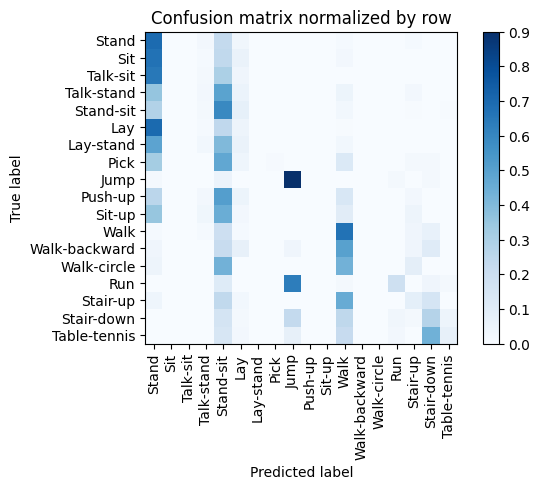

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-09-23 08:15:20,807 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 7.425526857376099 seconds

2022-09-23 08:15:20,807 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 8.316960771878561 seconds
2022-09-23 08:15:20,808 | INFO : Avg batch val. time: 0.14096543681150103 seconds
2022-09-23 08:15:20,808 | INFO : Avg sample val. time: 0.004452334460320429 seconds
2022-09-23 08:15:20,811 | INFO : Epoch 5 Validation Summary: epoch: 5.000000 | loss: 0.070991 | accuracy: 0.209315 | precision: 0.307891 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (w

Overall accuracy: 0.209

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.186      0.592      0.283      0.105        196|	 Stand: 0.281,	Lay: 0.077,	
        Stand       0.161      0.694      0.262      0.091        170|	 Stand-sit: 0.229,	Lay: 0.029,	
          Sit       0.000      0.000      0.000      0.090        169|	 Stand: 0.669,	Stand-sit: 0.237,	Lay: 0.059,	
   Talk-stand       0.148      0.024      0.041      0.090        168|	 Stand-sit: 0.494,	Stand: 0.357,	Lay: 0.054,	
          Lay       0.091      0.043      0.058      0.087        163|	 Stand: 0.699,	Stand-sit: 0.239,	
     Talk-sit       0.000      0.000      0.000      0.087        162|	 Stand: 0.648,	Stand-sit: 0.296,	Lay: 0.037,	
    Lay-stand       0.000      0.000      0.000      0.085        159|	 Stand: 0.491,	Stand-sit: 0.403,	Lay: 0.057,	
         Pick       1.000      0.008      0.017      0.064        120|	 Stand-sit: 0.475,	Stand: 0.317,	Walk: 0

2022-09-23 08:19:11,060 | INFO : Epoch 6 Training Summary: epoch: 6.000000 | loss: 0.069276 | 
2022-09-23 08:19:11,061 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 50.229459285736084 seconds

2022-09-23 08:19:11,062 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 38.32472320397696 seconds
2022-09-23 08:19:11,063 | INFO : Avg batch train. time: 0.4150660136957737 seconds
2022-09-23 08:19:11,064 | INFO : Avg sample train. time: 0.012990879638461083 seconds
2022-09-23 08:19:11,067 | INFO : Evaluating on validation set ...


Evaluating Epoch 6  98.3% | batch:        58 of        59	|	loss: 2.12376

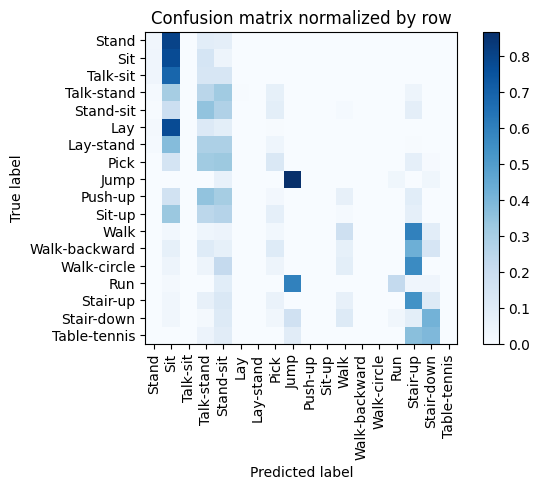

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-09-23 08:19:18,418 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 7.350995302200317 seconds

2022-09-23 08:19:18,419 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 8.17896570478167 seconds
2022-09-23 08:19:18,419 | INFO : Avg batch val. time: 0.13862653736918085 seconds
2022-09-23 08:19:18,420 | INFO : Avg sample val. time: 0.004378461298062992 seconds
2022-09-23 08:19:18,424 | INFO : Epoch 6 Validation Summary: epoch: 6.000000 | loss: 0.067127 | accuracy: 0.210385 | precision: 0.220284 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (wh

Overall accuracy: 0.210

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.166      0.276      0.207      0.105        196|	 Talk-stand: 0.352,	Sit: 0.189,	
        Stand       0.200      0.029      0.051      0.091        170|	 Sit: 0.800,	Talk-stand: 0.088,	Stand-sit: 0.082,	
          Sit       0.183      0.775      0.296      0.090        169|	 Talk-stand: 0.148,	Stand-sit: 0.041,	
   Talk-stand       0.128      0.250      0.169      0.090        168|	 Stand-sit: 0.315,	Sit: 0.304,	
          Lay       0.000      0.000      0.000      0.087        163|	 Sit: 0.773,	Talk-stand: 0.117,	Stand-sit: 0.086,	
     Talk-sit       0.000      0.000      0.000      0.087        162|	 Sit: 0.685,	Talk-stand: 0.142,	Stand-sit: 0.136,	
    Lay-stand       0.000      0.000      0.000      0.085        159|	 Sit: 0.377,	Talk-stand: 0.283,	Stand-sit: 0.283,	
         Pick       0.211      0.125      0.157      0.064        120|	 Stand-sit

2022-09-23 08:23:02,513 | INFO : Epoch 7 Training Summary: epoch: 7.000000 | loss: 0.067455 | 
2022-09-23 08:23:02,515 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 44.067904472351074 seconds

2022-09-23 08:23:02,516 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 39.145177670887534 seconds
2022-09-23 08:23:02,517 | INFO : Avg batch train. time: 0.41662581306252383 seconds
2022-09-23 08:23:02,518 | INFO : Avg sample train. time: 0.013039698778465282 seconds
2022-09-23 08:23:02,519 | INFO : Evaluating on validation set ...


Evaluating Epoch 7  98.3% | batch:        58 of        59	|	loss: 2.03943

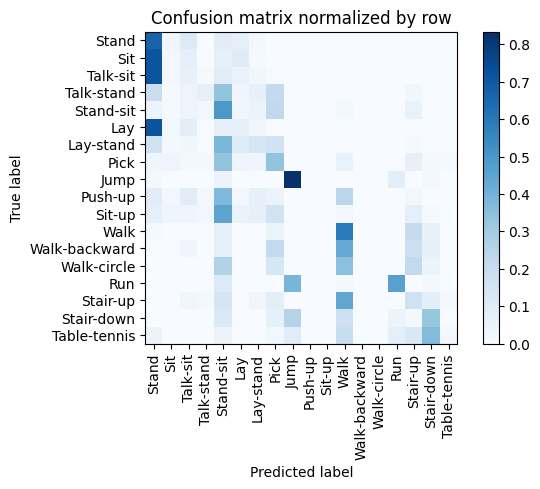

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-09-23 08:23:09,935 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 7.414322137832642 seconds

2022-09-23 08:23:09,936 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 8.08338525891304 seconds
2022-09-23 08:23:09,937 | INFO : Avg batch val. time: 0.13700652981208541 seconds
2022-09-23 08:23:09,937 | INFO : Avg sample val. time: 0.004327294035820686 seconds
2022-09-23 08:23:09,940 | INFO : Epoch 7 Validation Summary: epoch: 7.000000 | loss: 0.062762 | accuracy: 0.249465 | precision: 0.255082 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (wh

Overall accuracy: 0.249

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.238      0.495      0.321      0.105        196|	 Pick: 0.219,	Stair-up: 0.056,	
        Stand       0.205      0.665      0.313      0.091        170|	 Talk-sit: 0.106,	Stand-sit: 0.094,	
          Sit       0.118      0.024      0.039      0.090        169|	 Stand: 0.716,	Lay: 0.101,	Talk-sit: 0.077,	
   Talk-stand       0.440      0.065      0.114      0.090        168|	 Stand-sit: 0.333,	Pick: 0.208,	Stand: 0.185,	
          Lay       0.133      0.074      0.095      0.087        163|	 Stand: 0.718,	Talk-sit: 0.080,	
     Talk-sit       0.116      0.062      0.081      0.087        162|	 Stand: 0.716,	Stand-sit: 0.093,	
    Lay-stand       0.284      0.132      0.180      0.085        159|	 Stand-sit: 0.384,	Stand: 0.157,	Pick: 0.157,	
         Pick       0.216      0.333      0.262      0.064        120|	 Stand-sit: 0.333,	Stair-up: 0.067,	
      

2022-09-23 08:27:05,479 | INFO : Epoch 8 Training Summary: epoch: 8.000000 | loss: 0.064272 | 
2022-09-23 08:27:05,479 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 55.51100015640259 seconds

2022-09-23 08:27:05,480 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 41.19090548157692 seconds
2022-09-23 08:27:05,481 | INFO : Avg batch train. time: 0.42051502943265573 seconds
2022-09-23 08:27:05,481 | INFO : Avg sample train. time: 0.013161424817420976 seconds
2022-09-23 08:27:05,485 | INFO : Evaluating on validation set ...


Evaluating Epoch 8  98.3% | batch:        58 of        59	|	loss: 1.88093

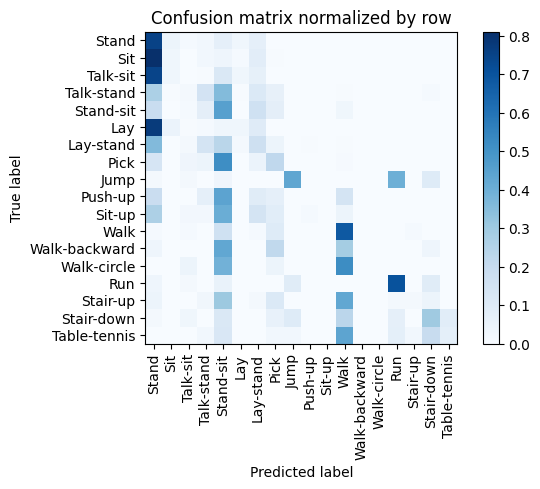

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-09-23 08:27:13,305 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 7.817185163497925 seconds

2022-09-23 08:27:13,306 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 8.053807470533583 seconds
2022-09-23 08:27:13,307 | INFO : Avg batch val. time: 0.13650521136497598 seconds
2022-09-23 08:27:13,308 | INFO : Avg sample val. time: 0.004311460101998706 seconds
2022-09-23 08:27:13,311 | INFO : Epoch 8 Validation Summary: epoch: 8.000000 | loss: 0.063092 | accuracy: 0.239829 | precision: 0.241258 | 
Training Epoch:  80%|████████  | 8/10 [30:27<07:47, 233.67s/it]

Overall accuracy: 0.240

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.212      0.454      0.289      0.105        196|	 Stand: 0.189,	Lay-stand: 0.163,	
        Stand       0.181      0.753      0.292      0.091        170|	 Stand-sit: 0.071,	Lay-stand: 0.071,	
          Sit       0.192      0.030      0.051      0.090        169|	 Stand: 0.811,	Lay-stand: 0.083,	Stand-sit: 0.036,	
   Talk-stand       0.287      0.149      0.196      0.090        168|	 Stand-sit: 0.357,	Stand: 0.268,	
          Lay       0.238      0.031      0.054      0.087        163|	 Stand: 0.773,	Lay-stand: 0.098,	Sit: 0.049,	
     Talk-sit       0.000      0.000      0.000      0.087        162|	 Stand: 0.747,	Stand-sit: 0.117,	Lay-stand: 0.068,	
    Lay-stand       0.173      0.170      0.171      0.085        159|	 Stand: 0.358,	Stand-sit: 0.233,	
         Pick       0.263      0.217      0.237      0.064        120|	 Stand-sit: 0.517,	Stand: 0.

2022-09-23 08:31:11,624 | INFO : Epoch 9 Training Summary: epoch: 9.000000 | loss: 0.061757 | 
2022-09-23 08:31:11,627 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 58.308541774749756 seconds

2022-09-23 08:31:11,628 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 43.092865069707244 seconds
2022-09-23 08:31:11,631 | INFO : Avg batch train. time: 0.4241309221857552 seconds
2022-09-23 08:31:11,633 | INFO : Avg sample train. time: 0.013274596279287591 seconds
2022-09-23 08:31:11,637 | INFO : Evaluating on validation set ...


Evaluating Epoch 9  98.3% | batch:        58 of        59	|	loss: 1.93461

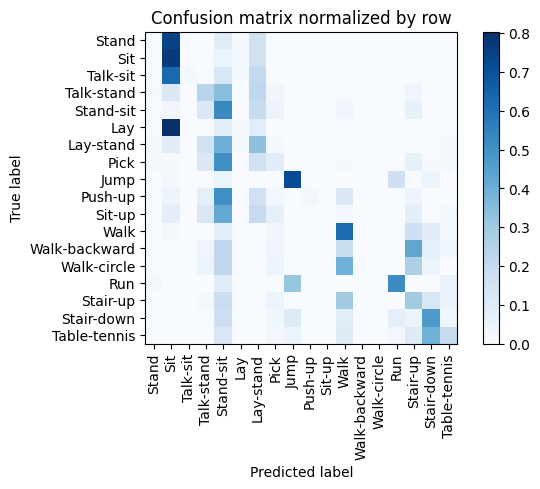

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-09-23 08:31:19,655 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 8.015512704849243 seconds

2022-09-23 08:31:19,656 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 8.049977993965149 seconds
2022-09-23 08:31:19,658 | INFO : Avg batch val. time: 0.13644030498246015 seconds
2022-09-23 08:31:19,659 | INFO : Avg sample val. time: 0.00430941006100918 seconds
2022-09-23 08:31:19,661 | INFO : Epoch 9 Validation Summary: epoch: 9.000000 | loss: 0.060139 | accuracy: 0.281049 | precision: 0.314142 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (wh

Overall accuracy: 0.281

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.226      0.526      0.316      0.105        196|	 Lay-stand: 0.194,	Talk-stand: 0.112,	
        Stand       0.000      0.000      0.000      0.091        170|	 Sit: 0.741,	Lay-stand: 0.159,	Stand-sit: 0.088,	
          Sit       0.241      0.769      0.367      0.090        169|	 Lay-stand: 0.160,	Stand-sit: 0.047,	
   Talk-stand       0.339      0.238      0.280      0.090        168|	 Stand-sit: 0.345,	Lay-stand: 0.214,	
          Lay       0.182      0.012      0.023      0.087        163|	 Sit: 0.804,	Lay-stand: 0.086,	Stand-sit: 0.080,	
     Talk-sit       0.600      0.019      0.036      0.087        162|	 Sit: 0.630,	Lay-stand: 0.210,	Stand-sit: 0.123,	
    Lay-stand       0.194      0.333      0.245      0.085        159|	 Stand-sit: 0.396,	Talk-stand: 0.151,	
         Pick       0.250      0.092      0.134      0.064        120|	 Stand-sit: 0.

2022-09-23 08:35:08,361 | INFO : Epoch 10 Training Summary: epoch: 10.000000 | loss: 0.061666 | 
2022-09-23 08:35:08,362 | INFO : Epoch runtime: 0.0 hours, 3.0 minutes, 48.664013624191284 seconds

2022-09-23 08:35:08,363 | INFO : Avg epoch train. time: 0.0 hours, 3.0 minutes, 43.649979925155634 seconds
2022-09-23 08:35:08,364 | INFO : Avg batch train. time: 0.4251900759033377 seconds
2022-09-23 08:35:08,365 | INFO : Avg sample train. time: 0.013307746038626422 seconds
2022-09-23 08:35:08,366 | INFO : Evaluating on validation set ...


Evaluating Epoch 10  98.3% | batch:        58 of        59	|	loss: 2.16703

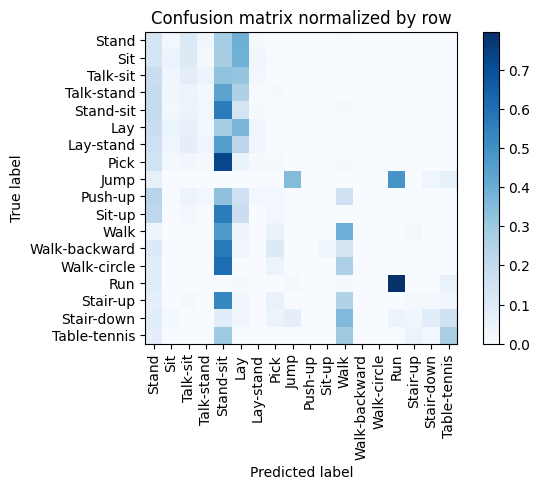

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-09-23 08:35:15,879 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 7.511197090148926 seconds

2022-09-23 08:35:15,879 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 8.000997911800038 seconds
2022-09-23 08:35:15,880 | INFO : Avg batch val. time: 0.13561013409830572 seconds
2022-09-23 08:35:15,881 | INFO : Avg sample val. time: 0.004283189460278393 seconds
2022-09-23 08:35:15,887 | INFO : Epoch 10 Validation Summary: epoch: 10.000000 | loss: 0.073336 | accuracy: 0.179872 | precision: 0.189930 | 
2022-09-23 08:35:15,896 | INFO : Best loss was 0.06013867424948568. Other metrics: OrderedDict([('epoch', 9), ('loss', 0.06013867424948568), ('accuracy', 0.281

Overall accuracy: 0.180

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.152      0.561      0.240      0.105        196|	 Stand: 0.194,	Lay: 0.138,	
        Stand       0.086      0.141      0.107      0.091        170|	 Lay: 0.394,	Stand-sit: 0.282,	
          Sit       0.186      0.047      0.075      0.090        169|	 Lay: 0.385,	Stand-sit: 0.272,	Stand: 0.136,	
   Talk-stand       0.088      0.018      0.030      0.090        168|	 Stand-sit: 0.435,	Lay: 0.256,	Stand: 0.190,	
          Lay       0.155      0.368      0.218      0.087        163|	 Stand-sit: 0.282,	Stand: 0.178,	
     Talk-sit       0.140      0.080      0.102      0.087        162|	 Stand-sit: 0.321,	Lay: 0.315,	Stand: 0.179,	
    Lay-stand       0.154      0.025      0.043      0.085        159|	 Stand-sit: 0.453,	Lay: 0.226,	Stand: 0.164,	
         Pick       0.043      0.008      0.014      0.064        120|	 Stand-sit: 0.725,	Stand: 0.150,	Lay: 0.

In [13]:
# Evaluate on validation before training
aggr_metrics_val, best_metrics, best_value = validate(val_evaluator, tensorboard_writer, config, best_metrics,
                                                        best_value, epoch=0, class_names=config['class_names'])
metrics_names, metrics_values = zip(*aggr_metrics_val.items())
metrics.append(list(metrics_values))

logger.info('Starting training...')
for epoch in tqdm(range(start_epoch + 1, config["epochs"] + 1), desc='Training Epoch', leave=False):
    mark = epoch if config['save_all'] else 'last'
    epoch_start_time = time.time()
    aggr_metrics_train = trainer.train_epoch(epoch)  # dictionary of aggregate epoch metrics
    # print(f"train metrics >> {aggr_metrics_train}")
    run['train/loss'].log(aggr_metrics_train['loss'])
    epoch_runtime = time.time() - epoch_start_time
    print_str = 'Epoch {} Training Summary: '.format(epoch)
    for k, v in aggr_metrics_train.items():
        tensorboard_writer.add_scalar('{}/train'.format(k), v, epoch)
        print_str += '{}: {:8f} | '.format(k, v)
    logger.info(print_str)
    logger.info("Epoch runtime: {} hours, {} minutes, {} seconds\n".format(*utils.readable_time(epoch_runtime)))
    total_epoch_time += epoch_runtime
    avg_epoch_time = total_epoch_time / (epoch - start_epoch)
    avg_batch_time = avg_epoch_time / len(train_loader)
    avg_sample_time = avg_epoch_time / len(train_dataset)
    logger.info("Avg epoch train. time: {} hours, {} minutes, {} seconds".format(*utils.readable_time(avg_epoch_time)))
    logger.info("Avg batch train. time: {} seconds".format(avg_batch_time))
    logger.info("Avg sample train. time: {} seconds".format(avg_sample_time))

    # evaluate if first or last epoch or at specified interval
    if (epoch == config["epochs"]) or (epoch == start_epoch + 1) or (epoch % config['val_interval'] == 0):
        aggr_metrics_val, best_metrics, best_value = validate(val_evaluator, tensorboard_writer, config,
                                                                best_metrics, best_value, epoch, config['class_names'])
        # print(f"eval metrics >> {aggr_metrics_val}")
        run['eval/loss'].log(aggr_metrics_val['loss'])
        run['eval/accuracy'].log(aggr_metrics_val['accuracy'])
        run['eval/precision'].log(aggr_metrics_val['precision'])
        metrics_names, metrics_values = zip(*aggr_metrics_val.items())
        metrics.append(list(metrics_values))

    # utils.save_model(os.path.join(config['save_dir'], 'model_{}.pth'.format(mark)), epoch, model, optimizer)

    # Learning rate scheduling
    if epoch == config['lr_step'][lr_step]:
        utils.save_model(os.path.join(config['save_dir'], 'model_{}.pth'.format(epoch)), epoch, model, optimizer)
        lr = lr * config['lr_factor'][lr_step]
        if lr_step < len(config['lr_step']) - 1:  # so that this index does not get out of bounds
            lr_step += 1
        logger.info('Learning rate updated to: ', lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    # Difficulty scheduling
    if config['harden'] and check_progress(epoch):
        train_loader.dataset.update()
        val_loader.dataset.update()

# Export evolution of metrics over epochs
# header = metrics_names #@nipdep
# metrics_filepath = os.path.join(config["output_dir"], "metrics_" + config["experiment_name"] + ".xls")
# book = utils.export_performance_metrics(metrics_filepath, metrics, header, sheet_name="metrics")

# # Export record metrics to a file accumulating records from all experiments
# utils.register_record(config["records_file"], config["initial_timestamp"], config["experiment_name"],
#                         best_metrics, aggr_metrics_val, comment=config['comment'])

logger.info('Best {} was {}. Other metrics: {}'.format(config['key_metric'], best_value, best_metrics))
logger.info('All Done!')

total_runtime = time.time() - total_start_time
logger.info("Total runtime: {} hours, {} minutes, {} seconds\n".format(*utils.readable_time(total_runtime)))

run.stop()

In [14]:
config["class_names"]

['Stand',
 'Sit',
 'Talk-sit',
 'Talk-stand',
 'Stand-sit',
 'Lay',
 'Lay-stand',
 'Pick',
 'Jump',
 'Push-up',
 'Sit-up',
 'Walk',
 'Walk-backward',
 'Walk-circle',
 'Run',
 'Stair-up',
 'Stair-down',
 'Table-tennis']

In [15]:
from copy import deepcopy

model_path = './tmp/first_test/checkpoints/prep_model_last.pth'
checkpoint = torch.load(model_path)
state_dict = deepcopy(checkpoint['state_dict'])
for key, val in checkpoint['state_dict'].items():
            if key.startswith('output_layer'):
                state_dict.pop(key)

model.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['conv1d.weight', 'conv1d.bias', 'output_layer.weight', 'output_layer.bias'], unexpected_keys=[])

In [16]:
model.eval()
for i in val_loader:
    x, y, m, ids = i
    x = x.to(device)
    m = m.to(device)
    pred = model(x, m)
    break

In [17]:
pred.shape

torch.Size([32, 18])

In [18]:
probs = torch.softmax(pred, dim=-1)
pred_label = torch.argmax(probs, dim=-1)
pred_label.shape

torch.Size([32])

In [19]:
pred_label

tensor([12, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
       device='cuda:0')

In [20]:
y

tensor([13,  2, 14,  4,  4,  1,  4,  3, 15, 17,  4, 11, 17,  1,  5, 11,  5,  4,
         0,  2,  3,  6,  5, 12,  4,  9, 15, 10,  1, 15,  2,  0])

In [21]:
model.transformer_encoder.layers[0].linear1.weight.grad

tensor([[ 1.1322e-02,  1.5054e-02,  1.6847e-02,  ..., -1.0079e-02,
         -7.8883e-03,  2.2434e-02],
        [ 5.0889e-05, -5.2174e-03, -1.6386e-02,  ...,  4.2455e-02,
          2.5319e-02, -1.9644e-02],
        [-1.0029e-02, -1.3525e-02, -1.9005e-02,  ..., -1.6927e-02,
          3.1119e-03,  6.5516e-03],
        ...,
        [ 8.7264e-03,  2.7422e-02,  5.1469e-02,  ..., -1.0549e-02,
         -2.7310e-02,  2.1136e-02],
        [ 1.3502e-02,  6.1946e-02,  4.3897e-02,  ..., -6.6509e-03,
         -2.9909e-02,  3.5945e-02],
        [-1.0317e-02,  3.0794e-02,  3.7055e-02,  ..., -2.7887e-02,
         -2.5379e-02,  5.4412e-02]], device='cuda:0')

In [25]:
# test 1D-Conv layer
from torch import nn


In [24]:
conv_layer = nn.Conv1d(300, 1, 1)
sample_inp = torch.rand((32, 300, 128))
sample_out = conv_layer(sample_inp)
sample_out.shape

torch.Size([32, 1, 128])

In [32]:
pool_layer = nn.AdaptiveAvgPool2d((5,7))
sample_input = torch.rand((32, 300, 128))
sample_out = pool_layer(sample_input)
sample_out.shape

torch.Size([32, 5, 7])

In [35]:
pool_layer = nn.AvgPool2d((300,1))
sample_input = torch.rand((32, 300, 128))
sample_out = pool_layer(sample_input)
sample_out.shape

torch.Size([32, 1, 128])